In [1]:
# install libraries and packages
# !pip install geopandas
# !pip install fiona
# !pip install rioxarray
# !pip install rasterio
# !pip install rasterstats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import rioxarray as rxr
from rasterio.enums import Resampling
from rasterstats import zonal_stats

# Save grid dataframes (10km, 25km, 50km, and 100km cell sizes)

Layers: ['africa_grid_10km', 'africa_grid_25km', 'africa_grid_50km', 'africa_grid_100km']


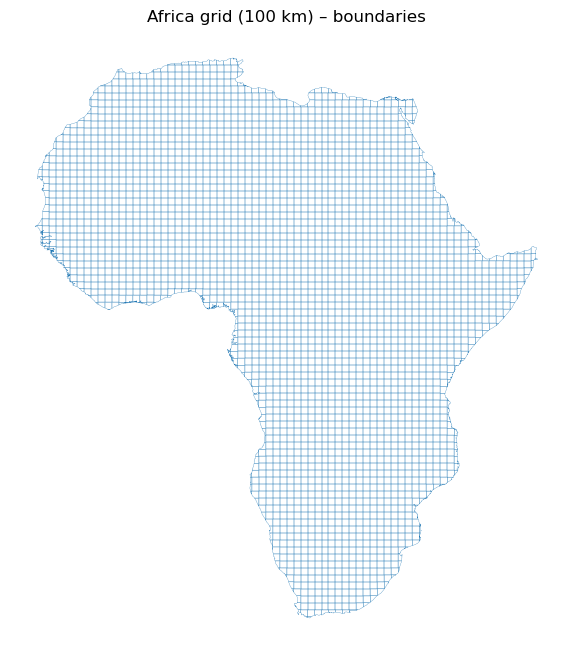

,id,left,top,right,bottom,row_index,col_index,geometry,cell_id,area_km2
0,16,-4.440354e+06,2.594190e+06,-4.340354e+06,2.494190e+06,15,0,"MULTIPOLYGON (((-4379925.239 2512293.782, -437...",0,1470.721709
1,17,-4.440354e+06,2.494190e+06,-4.340354e+06,2.394190e+06,16,0,"MULTIPOLYGON (((-4383777.578 2395504.385, -438...",1,5608.520868
2,18,-4.440354e+06,2.394190e+06,-4.340354e+06,2.294190e+06,17,0,"MULTIPOLYGON (((-4340462.002 2350585.846, -434...",2,1516.129525
3,19,-4.440354e+06,2.294190e+06,-4.340354e+06,2.194190e+06,18,0,"MULTIPOLYGON (((-4340370.242 2202587.665, -434...",3,19.280008
4,23,-4.440354e+06,1.894190e+06,-4.340354e+06,1.794190e+06,22,0,"MULTIPOLYGON (((-4340354.478 1801073.221, -434...",4,12.852028


In [2]:
# import all grid versions in EPSG:102022
layers = fiona.listlayers("data/Africa_grid_102022.gpkg")
print("Layers:", layers)
grid_10km  = gpd.read_file("data/Africa_grid_102022.gpkg", layer="africa_grid_10km").to_crs("ESRI:102022")
grid_25km  = gpd.read_file("data/Africa_grid_102022.gpkg", layer="africa_grid_25km").to_crs("ESRI:102022")
grid_50km  = gpd.read_file("data/Africa_grid_102022.gpkg", layer="africa_grid_50km").to_crs("ESRI:102022")
grid_100km = gpd.read_file("data/Africa_grid_102022.gpkg", layer="africa_grid_100km").to_crs("ESRI:102022")

# Save dataframe for each grid
def add_id_area(gdf):
    gdf = gdf.reset_index(drop=True)
    gdf["cell_id"] = gdf.index.astype("int64")
    gdf["area_km2"] = gdf.geometry.area / 1e6  # m² -> km²
    return gdf
grid_10km  = add_id_area(grid_10km)
grid_25km  = add_id_area(grid_25km)
grid_50km  = add_id_area(grid_50km)
grid_100km = add_id_area(grid_100km)

# Visualize grid cells
fig, ax = plt.subplots(figsize=(8, 8))
grid_100km.boundary.plot(ax=ax, linewidth=0.2)
ax.set_title("Africa grid (100 km) – boundaries")
ax.set_axis_off()
plt.show()

# Show dataframe
grid_100km.head()

----------

# Compute counts of conflict incidents per grid cell

### Total conflict incidents

In [3]:
# import ACLED conflict data (EPSG:4326)
conflict_data = gpd.read_file("data/ACLED_conflict-data_africa_2020-2024_4326.gpkg")
conflict_data = conflict_data.to_crs("ESRI:102022")

# fix any invalid grid geometries
grid_10km["geometry"] = grid_10km.geometry.make_valid()

# spatial join: each point gets the cell_id it falls in
pts_with_cellid = gpd.sjoin(conflict_data[["geometry"]],grid_10km[["cell_id", "geometry"]],how="left",predicate="within") # predicate="within" avoids double-counting boundary points, but may drop exact-on-boundary cases

# count points per cell_id
incident_counts = pts_with_cellid.groupby("cell_id").size().rename("incident_count")

# join back to grid; fill empty with zero
grid_10km = grid_10km.join(incident_counts, on="cell_id")
grid_10km["incident_count"] = grid_10km["incident_count"].fillna(0).astype("int64")

# check unmatched points (if high consider changing to predicate="intersects"
print("Total ACLED points:", len(conflict_data))
print("Matched to a cell:", pts_with_cellid["cell_id"].notna().sum())
print("Unmatched:", pts_with_cellid["cell_id"].isna().sum())
print("Grid sum incidents:", grid_10km["incident_count"].sum())

# inspect dataframe
grid_10km.head()

Total ACLED points: 197140
Matched to a cell: 197140
Unmatched: 0
Grid sum incidents: 197140


,id,left,top,right,bottom,row_index,col_index,geometry,cell_id,area_km2,incident_count
0,241,-4.440354e+06,1.694190e+06,-4.430354e+06,1.684190e+06,240,0,"MULTIPOLYGON (((-4438668.496 1685614.099, -444...",0,40.913185,5
1,242,-4.440354e+06,1.684190e+06,-4.430354e+06,1.674190e+06,241,0,"MULTIPOLYGON (((-4431485.105 1676494.905, -443...",1,32.444992,11
2,1042,-4.430354e+06,1.704190e+06,-4.420354e+06,1.694190e+06,239,1,"MULTIPOLYGON (((-4420354.478 1694991.355, -442...",2,0.357439,0
3,1043,-4.430354e+06,1.694190e+06,-4.420354e+06,1.684190e+06,240,1,"MULTIPOLYGON (((-4422310.661 1685092.152, -442...",3,69.284336,36
4,1044,-4.430354e+06,1.684190e+06,-4.420354e+06,1.674190e+06,241,1,"MULTIPOLYGON (((-4430237.063 1683369.85, -4429...",4,9.327453,280


### Counts by incident type

In [4]:
# 1) spatial join (keep EVENT_TYPE + cell_id)
pts = gpd.sjoin(conflict_data[["EVENT_TYPE", "geometry"]],grid_10km[["cell_id", "geometry"]],how="left",predicate="within")

# 2) counts per cell per event type -> wide columns
counts_wide = (pts.groupby(["cell_id", "EVENT_TYPE"]).size().unstack(fill_value=0))

# 3) clean column names
counts_wide.columns = ["count_" + str(c).lower().replace("/", "_").replace(" ", "_").replace("-", "_") for c in counts_wide.columns]

# 4) join to grid (safe overwrite if re-running)
grid_10km = grid_10km.drop(columns=counts_wide.columns, errors="ignore")
grid_10km = grid_10km.join(counts_wide, on="cell_id")

# 5) fix nans
event_cols = counts_wide.columns.tolist()
grid_10km[event_cols] = grid_10km[event_cols].fillna(0).astype("int64")

# 6) compute total
grid_10km["count_total"] = grid_10km[event_cols].sum(axis=1).astype("int64")

# Check counts
grid_10km[[c for c in grid_10km.columns if c.startswith("cnt_")]].sum().sort_values(ascending=False)

Series([], dtype: float64)

# Compute estimated population per grid cell

In [5]:
# use population density raster to estimate population based on grid cell area size
popdens = rxr.open_rasterio("data/GPW_popdensity_africa_4326.tif", masked=True).squeeze()

nodata = popdens.rio.nodata
if nodata is None:
    nodata = -9999
print("Using nodata:", nodata)

popdens_aea = popdens.rio.reproject(grid_10km.crs,resolution=5000,resampling=Resampling.average,nodata=nodata)

px_w, px_h = popdens_aea.rio.resolution()
pixel_area_km2 = abs(px_w * px_h) / 1e6
people_per_pixel = popdens_aea * pixel_area_km2

grid_10km["pop_est"] = 0.0
chunk_size = 5000

for start in range(0, len(grid_10km), chunk_size):
    chunk = grid_10km.iloc[start:start+chunk_size]
    zs = zonal_stats(chunk,np.asarray(people_per_pixel.values),affine=people_per_pixel.rio.transform(),nodata=nodata,stats=["sum"],all_touched=False)
    grid_10km.loc[chunk.index, "pop_est"] = [d["sum"] if d["sum"] is not None else 0 for d in zs]

grid_10km["pop_est"] = grid_10km["pop_est"].round().astype("int64")

grid_10km.head()

Using nodata: nan


,id,left,top,right,bottom,row_index,col_index,geometry,cell_id,area_km2,incident_count,count_battles,count_explosions_remote_violence,count_protests,count_riots,count_strategic_developments,count_violence_against_civilians,count_total,pop_est
0,241,-4.440354e+06,1.694190e+06,-4.430354e+06,1.684190e+06,240,0,"MULTIPOLYGON (((-4438668.496 1685614.099, -444...",0,40.913185,5,0,0,2,2,1,0,5,153048
1,242,-4.440354e+06,1.684190e+06,-4.430354e+06,1.674190e+06,241,0,"MULTIPOLYGON (((-4431485.105 1676494.905, -443...",1,32.444992,11,0,0,4,6,1,0,11,229572
2,1042,-4.430354e+06,1.704190e+06,-4.420354e+06,1.694190e+06,239,1,"MULTIPOLYGON (((-4420354.478 1694991.355, -442...",2,0.357439,0,0,0,0,0,0,0,0,0
3,1043,-4.430354e+06,1.694190e+06,-4.420354e+06,1.684190e+06,240,1,"MULTIPOLYGON (((-4422310.661 1685092.152, -442...",3,69.284336,36,0,0,9,22,4,1,36,229572
4,1044,-4.430354e+06,1.684190e+06,-4.420354e+06,1.674190e+06,241,1,"MULTIPOLYGON (((-4430237.063 1683369.85, -4429...",4,9.327453,280,1,0,126,98,48,7,280,0


# Compute paved road kilometers per grid cell

In [6]:
# import roads and reproject to equidistant crs
roads = gpd.read_file("data/Africa_roads_4326.gpkg")
crs_len = "ESRI:102023"
roads_len = roads.to_crs(crs_len)
grid_len = grid_10km.to_crs(crs_len)

# keep only line geometries; drop empties
roads_len = roads_len[roads_len.geometry.notna()].copy()
roads_len = roads_len[~roads_len.geometry.is_empty].copy()

# fix invalid geometries
roads_len["geometry"] = roads_len.geometry.make_valid()
grid_len["geometry"] = grid_len.geometry.make_valid()

# spatial index overlay (intersection) creates road segments clipped to each cell polygon
roads_x = gpd.overlay(roads_len[["geometry"]],grid_len[["cell_id", "geometry"]],how="intersection",keep_geom_type=True)

# length in km
roads_x["road_km"] = roads_x.geometry.length / 1000.0

# sum per cell
road_km_by_cell = roads_x.groupby("cell_id")["road_km"].sum()

# write back onto main grid_10km (in 102022) by cell_id
grid_10km["road_km"] = grid_10km["cell_id"].map(road_km_by_cell).fillna(0.0)

grid_10km.head()

,id,left,top,right,bottom,row_index,col_index,geometry,cell_id,area_km2,incident_count,count_battles,count_explosions_remote_violence,count_protests,count_riots,count_strategic_developments,count_violence_against_civilians,count_total,pop_est,road_km
0,241,-4.440354e+06,1.694190e+06,-4.430354e+06,1.684190e+06,240,0,"MULTIPOLYGON (((-4438668.496 1685614.099, -444...",0,40.913185,5,0,0,2,2,1,0,5,153048,12.537470
1,242,-4.440354e+06,1.684190e+06,-4.430354e+06,1.674190e+06,241,0,"MULTIPOLYGON (((-4431485.105 1676494.905, -443...",1,32.444992,11,0,0,4,6,1,0,11,229572,16.945375
2,1042,-4.430354e+06,1.704190e+06,-4.420354e+06,1.694190e+06,239,1,"MULTIPOLYGON (((-4420354.478 1694991.355, -442...",2,0.357439,0,0,0,0,0,0,0,0,0,0.000000
3,1043,-4.430354e+06,1.694190e+06,-4.420354e+06,1.684190e+06,240,1,"MULTIPOLYGON (((-4422310.661 1685092.152, -442...",3,69.284336,36,0,0,9,22,4,1,36,229572,6.069887
4,1044,-4.430354e+06,1.684190e+06,-4.420354e+06,1.674190e+06,241,1,"MULTIPOLYGON (((-4430237.063 1683369.85, -4429...",4,9.327453,280,1,0,126,98,48,7,280,0,13.382641


# Compute distance between cell centroid and nearest national border

In [7]:
#import borders data
borders = gpd.read_file("data/africa_national-borders_102023.gpkg")
print("Borders CRS:", borders.crs)

# set target crs for distance calculations in meters
crs_dist = "ESRI:102023"

# compute centroids
centroids = grid_10km[["cell_id", "geometry"]].copy()
centroids["geometry"] = centroids.geometry.centroid

# make sure both grid and border data are in crs for distance calculation
centroids = centroids.to_crs(crs_dist)
borders = borders.to_crs(crs_dist)

# drop empties + make valid
borders = borders[borders.geometry.notna() & ~borders.geometry.is_empty].copy()
borders["geometry"] = borders.geometry.make_valid()

# nearest border + distance (uses spatial index)
nearest = gpd.sjoin_nearest(
    centroids,
    borders[["geometry"]],
    how="left",
    distance_col="dist_border_m"
)

# attach back to grid_10km (in your original CRS) ---- FIXED
dist_by_cell = nearest.groupby("cell_id")["dist_border_m"].min()  # one value per cell_id
grid_10km["dist_border_m"] = grid_10km["cell_id"].map(dist_by_cell.to_dict())
grid_10km["dist_border_km"] = grid_10km["dist_border_m"] / 1000.0

grid_10km.head()

Borders CRS: PROJCS["Africa_Equidistant_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Equidistant_Conic"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",25],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",-23],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102023"]]


,id,left,top,right,bottom,row_index,col_index,geometry,cell_id,area_km2,...,count_explosions_remote_violence,count_protests,count_riots,count_strategic_developments,count_violence_against_civilians,count_total,pop_est,road_km,dist_border_m,dist_border_km
0,241,-4.440354e+06,1.694190e+06,-4.430354e+06,1.684190e+06,240,0,"MULTIPOLYGON (((-4438668.496 1685614.099, -444...",0,40.913185,...,0,2,2,1,0,5,153048,12.537470,152394.064255,152.394064
1,242,-4.440354e+06,1.684190e+06,-4.430354e+06,1.674190e+06,241,0,"MULTIPOLYGON (((-4431485.105 1676494.905, -443...",1,32.444992,...,0,4,6,1,0,11,229572,16.945375,155389.434713,155.389435
2,1042,-4.430354e+06,1.704190e+06,-4.420354e+06,1.694190e+06,239,1,"MULTIPOLYGON (((-4420354.478 1694991.355, -442...",2,0.357439,...,0,0,0,0,0,0,0,0.000000,138095.879609,138.095880
3,1043,-4.430354e+06,1.694190e+06,-4.420354e+06,1.684190e+06,240,1,"MULTIPOLYGON (((-4422310.661 1685092.152, -442...",3,69.284336,...,0,9,22,4,1,36,229572,6.069887,145226.850131,145.226850
4,1044,-4.430354e+06,1.684190e+06,-4.420354e+06,1.674190e+06,241,1,"MULTIPOLYGON (((-4430237.063 1683369.85, -4429...",4,9.327453,...,0,126,98,48,7,280,0,13.382641,152508.784180,152.508784


# Export to geopackage for regression analysis notebook

In [8]:
grid_10km.to_file("africa_grid_10km_stats.gpkg", driver="GPKG")